# Lab 1, Question 6

## Spectral reflectance curves
Next we we will generate a spectral reflectance curve for a given area.

This is a useful tool when you are considering if a given target has spectral characteristics for identification in ML.

### (6) If we want to apply multiple reducers to the same inputs what is a more efficient way to do so than just writing out a long series of sequential reducers on our end? (2 pts)

In [17]:
# Install the geemap package (only needs to be run once, uncomment below and run it the first time you run this notebook in a session).
# !pip install geemap

In [18]:
if 'google.colab' in str(get_ipython()):
    from google.colab import userdata
    EE_PROJECT_ID = userdata.get('EE_PROJECT_ID') 
else:
    from dotenv import load_dotenv
    import os
    load_dotenv()  # take environment variables
    EE_PROJECT_ID = os.getenv('EE_PROJECT_ID')

In [19]:
# Set up GEE API
import ee
ee.Authenticate()
ee.Initialize(project=EE_PROJECT_ID)

import matplotlib.pyplot as plt

In [20]:
# Define a point and a small rectangular region around it
point = ee.Geometry.Point([174.7633, -36.8485])  # Auckland, NZ
region = point.buffer(150).bounds()  # ~300 m box

# Load a Landsat 7 Collection 2 Level 2 SR image (surface reflectance)
image = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filterBounds(region) \
    .filterDate('2002-01-01', '2002-12-31') \
    .sort('CLOUD_COVER') \
    .first()
    
# Select surface reflectance bands and apply scale factor
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
band_names = {
    'SR_B1': 'Blue (0.45–0.52 μm)',
    'SR_B2': 'Green (0.52–0.60 μm)',
    'SR_B3': 'Red (0.63–0.69 μm)',
    'SR_B4': 'NIR (0.77–0.90 μm)',
    'SR_B5': 'SWIR1 (1.55–1.75 μm)',
    'SR_B7': 'SWIR2 (2.09–2.35 μm)'
}

scale_factor = 2.75e-5  # From USGS documentation for Landsat C2 L2

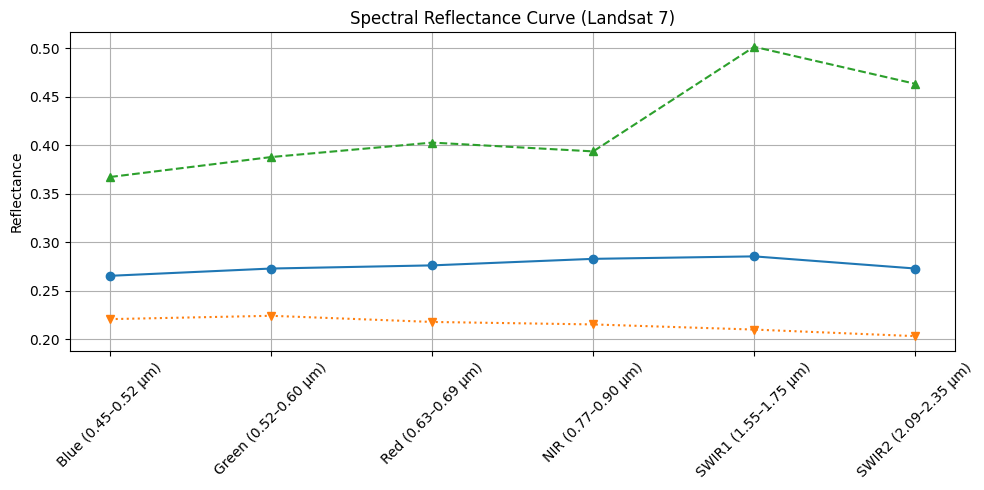

In [21]:
reducers = ee.Reducer.mean().combine(
      reducer2=ee.Reducer.min(), sharedInputs=True
    ).combine(
      reducer2=ee.Reducer.max(), sharedInputs=True
    )

# Use the combined reducer to get the mean and SD of the image.
stats = image.select(bands).reduceRegion(
    reducer=reducers,
    geometry=region,
    scale=30,
    maxPixels=1e6
)

stats_values = stats.getInfo()
mean_reflectances = [stats_values[f'{b}_mean'] * scale_factor for b in bands]
min_reflectances = [stats_values[f'{b}_min'] * scale_factor for b in bands]
max_reflectances = [stats_values[f'{b}_max'] * scale_factor for b in bands]

# Plot the spectral curve
plt.figure(figsize=(10, 5))
plt.plot(list(band_names.values()), mean_reflectances, marker='o', linestyle='-')
plt.plot(list(band_names.values()), min_reflectances, marker='v', linestyle=':')
plt.plot(list(band_names.values()), max_reflectances, marker='^', linestyle='--')
plt.title('Spectral Reflectance Curve (Landsat 7)')
plt.ylabel('Reflectance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()